# Desenvolvimento do Corona por UF
Esse trabalho mostra quantos dias demorou para cada estado ter seu desenvolvimento de casos.

In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Importing the Excel file with all the cities
# covid_munic = pd.read_excel("BRASILIO_2005 (version 1).xlsx")
covid_munic = pd.read_csv("caso_full.csv")
covid_munic["date"] = pd.to_datetime(covid_munic['date'], format="%Y/%m/%d")
covid_munic.head(1)

,city,city_ibge_code,date,epidemiological_week,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,São Paulo,3550308.0,2020-02-25,9,12252023.0,False,False,1,0.00816,2020-02-25,0.0,0,1,city,SP,1,0


In [3]:
# Understanding the data
covid_munic[covid_munic["city_ibge_code"] == 4307500.0] #[["date", "is_last", "is_repeated", "last_available_confirmed", "new_confirmed"]]

,city,city_ibge_code,date,epidemiological_week,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
13818,Espumoso,4307500.0,2020-04-13,16,15588.0,False,False,1,6.41519,2020-04-13,0.0000,0,1,city,RS,1,0
14940,Espumoso,4307500.0,2020-04-14,16,15588.0,False,False,1,6.41519,2020-04-14,0.0000,0,2,city,RS,0,0
16123,Espumoso,4307500.0,2020-04-15,16,15588.0,False,False,1,6.41519,2020-04-15,0.0000,0,3,city,RS,0,0
17370,Espumoso,4307500.0,2020-04-16,16,15588.0,False,False,1,6.41519,2020-04-16,0.0000,0,4,city,RS,0,0
18683,Espumoso,4307500.0,2020-04-17,16,15588.0,False,False,1,6.41519,2020-04-17,0.0000,0,5,city,RS,0,0
20057,Espumoso,4307500.0,2020-04-18,16,15588.0,False,False,1,6.41519,2020-04-18,0.0000,0,6,city,RS,0,0
21506,Espumoso,4307500.0,2020-04-19,17,15588.0,False,False,1,6.41519,2020-04-19,0.0000,0,7,city,RS,0,0
23004,Espumoso,4307500.0,2020-04-20,17,15588.0,False,False,1,6.41519,2020-04-20,0.0000,0,8,city,RS,0,0
24545,Espumoso,4307500.0,2020-04-21,17,15588.0,False,False,2,12.83038,2020-04-21,0.0000,0,9,city,RS,1,0
26143,Espumoso,4307500.0,2020-04-22,17,15588.0,False,False,3,19.24557,2020-04-22,0.0000,0,10,city,RS,1,0


In [4]:
# We have the data in 2 ways, by city (not all in there) and state, watch out to not duplicate
# We will use only place_type = "state" for this analysis
covid_munic.groupby("place_type")[["new_confirmed", "new_deaths"]].sum()

,new_confirmed,new_deaths
place_type,,
city,362366,22714
state,363340,22772


In [5]:
print("Last updated in: {:%d/%m/%Y}".format(max(covid_munic["date"])))

Last updated in: 24/05/2020


In [6]:
# We just need it by UF, so let's aggregate them
# Only leaving cases where we have at least one confirmed or one death
# And then create a cumulative frequency for confirmed cases and death 

covid_uf = covid_munic[covid_munic["place_type"] == "state"].groupby(["state", "date"])["new_confirmed", "new_deaths"].sum().reset_index()

covid_uf = covid_uf[(covid_uf["new_confirmed"] > 0) | (covid_uf["new_deaths"] > 0)]

covid_uf["date"] = pd.to_datetime(covid_uf['date'], format="%Y/%m/%d")

# Adding cumulative
covid_uf['Cumulative Confirmed'] = covid_uf.groupby('state')['new_confirmed'].cumsum()
covid_uf['Cumulative Death'] = covid_uf.groupby('state')['new_deaths'].cumsum()
covid_uf.tail(2)

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,state,date,new_confirmed,new_deaths,Cumulative Confirmed,Cumulative Death
1971,TO,2020-05-21,229,2,2205,49
1972,TO,2020-05-22,225,2,2430,51


In [7]:
print("First date: {:%d/%m/%Y}".format(min(covid_uf["date"])))
print("Last updated in: {:%d/%m/%Y}".format(max(covid_uf["date"])))
covid_uf[["new_confirmed", "new_deaths"]].sum()

First date: 25/02/2020
Last updated in: 24/05/2020


new_confirmed    363340
new_deaths        22772
dtype: int64

In [8]:
covid_uf.groupby("date")["state"].count().tail(10)

date
2020-05-15    26
2020-05-16    26
2020-05-17    27
2020-05-18    27
2020-05-19    26
2020-05-20    26
2020-05-21    25
2020-05-22    27
2020-05-23    24
2020-05-24    15
Name: state, dtype: int64

In [9]:
# Because we only have 15 states on our last date and 23 on our second last, we will delete both
# covid_uf = covid_uf[ covid_uf["date"] < max(covid_uf["date"])]
covid_uf = covid_uf[ covid_uf["date"] < max(pd.to_datetime(['2020-05-23'], format="%Y/%m/%d"))]

print("We have {} states with last updated in: {:%d/%m/%Y}".
      format(covid_uf[covid_uf["date"] == max(covid_uf["date"])] ["state"].count(), 
             max(covid_uf["date"])))

We have 27 states with last updated in: 22/05/2020


In [10]:
# Getting first cases in Brazil for confirmed and death
last_updated = max(covid_uf["date"])
first_br_confirmed = covid_uf[covid_uf["new_confirmed"] > 0]["date"].min()
first_br_death = covid_uf[covid_uf["new_deaths"] > 0]["date"].min()
print("First confirmed and death in Brasil: {:%d/%m/%Y} and {:%d/%m/%Y}".format(first_br_confirmed, first_br_death))

First confirmed and death in Brasil: 25/02/2020 and 17/03/2020


In [11]:
# Now let's get a summary for the UF
covid_uf_summary = covid_uf.groupby("state")["new_confirmed", "new_deaths"].sum()

#Creating a label for the graph with # cases
covid_uf_summary["Estado"] = [' - '.join(i) for i in 
                              zip(covid_uf_summary.index.values, covid_uf_summary["new_confirmed"].map(str) )]

# Create Region
region = {'AC': "Norte", 'AM': "Norte", 'AP': "Norte", 'PA': "Norte", 'RO': "Norte", 'RR': "Norte", 'TO': "Norte",
          'AL': "Nordeste", 'BA': "Nordeste", 'CE': "Nordeste", 'MA': "Nordeste", 'PB': "Nordeste", 'PE': "Nordeste", 
          'PI': "Nordeste", 'RN': "Nordeste", 'SE': "Nordeste", 
          'DF': "Centro Oeste", 'GO': "Centro Oeste", 'MS': "Centro Oeste", 'MT': "Centro Oeste",
          'ES': "Sudeste", 'MG': "Sudeste", 'RJ': "Sudeste", 'SP': "Sudeste",
          'PR': "Sul", 'SC': "Sul", 'RS': "Sul"}

covid_uf_summary['Region'] = covid_uf_summary.index.to_series().map(region)
# .apply(lambda x: region[x["state"]], axis=1)

covid_uf_summary.tail(2)

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,new_confirmed,new_deaths,Estado,Region
state,,,,
SP,76871,5773,SP - 76871,Sudeste
TO,2430,51,TO - 2430,Norte


In [12]:
covid_uf_summary.sum()

new_confirmed                                               334557
new_deaths                                                   21148
Estado           AC - 3343AL - 5302AM - 27038AP - 5655BA - 1255...
Region           NorteNordesteNorteNorteNordesteNordesteCentro ...
dtype: object

In [13]:
# Now we create the Dates and days since that we want
covid_uf_summary["Date Case 1 in UF"] = covid_uf[covid_uf["new_confirmed"] > 0].groupby("state")["date"].min()
covid_uf_summary["Date first death in UF"] = covid_uf[covid_uf["new_deaths"] > 0].groupby("state")["date"].min()
covid_uf_summary["Dias entre Caso 1 brasileiro e Caso 1 na UF"] = (covid_uf_summary["Date Case 1 in UF"] - first_br_confirmed).dt.days
covid_uf_summary["Dias entre Caso 1 brasileiro e morte na UF"] = (covid_uf_summary["Date first death in UF"] - first_br_confirmed).dt.days
covid_uf_summary["Dias entre Caso 1 e morte na UF"] = (covid_uf_summary["Date first death in UF"] - covid_uf_summary["Date Case 1 in UF"]).dt.days

#Creating variables for each slice - YOU CAN CHANGE THOSE NUMBERS IF YOU WANT
cases_slice = [1, 100, 500, 1000, 2000, 5000, 10000, 20000] #250, 
for s in range(1, len(cases_slice)):
    num_cases = cases_slice[s]
    num_cases_pre = cases_slice[s-1]
    covid_uf_summary["Date Case {} in UF".format(str(num_cases
                                                    ))] = covid_uf[covid_uf["Cumulative Confirmed"] > 
                                                                   num_cases].groupby("state")["date"].min()
    covid_uf_summary["Dias entre Caso {} e {} na UF".format(
        str(num_cases_pre), str(num_cases))] = (covid_uf_summary["Date Case {} in UF".format(str(num_cases
                                                    ))] - covid_uf_summary["Date Case {} in UF".format(str(num_cases_pre
                                                    ))]).dt.days
    

covid_uf_summary.tail(2)

,new_confirmed,new_deaths,Estado,Region,Date Case 1 in UF,Date first death in UF,Dias entre Caso 1 brasileiro e Caso 1 na UF,Dias entre Caso 1 brasileiro e morte na UF,Dias entre Caso 1 e morte na UF,Date Case 100 in UF,...,Date Case 1000 in UF,Dias entre Caso 500 e 1000 na UF,Date Case 2000 in UF,Dias entre Caso 1000 e 2000 na UF,Date Case 5000 in UF,Dias entre Caso 2000 e 5000 na UF,Date Case 10000 in UF,Dias entre Caso 5000 e 10000 na UF,Date Case 20000 in UF,Dias entre Caso 10000 e 20000 na UF
state,,,,,,,,,,,,,,,,,,,,,
SP,76871,5773,SP - 76871,Sudeste,2020-02-25,2020-03-17,0,21,21,2020-03-16,...,2020-03-26,4.0,2020-03-31,5.0,2020-04-07,7.0,2020-04-15,8.0,2020-04-25,10.0
TO,2430,51,TO - 2430,Norte,2020-03-18,2020-04-15,22,50,28,2020-04-28,...,2020-05-13,5.0,2020-05-21,8.0,NaT,NaN,NaT,NaN,NaT,NaN


In [14]:
# Function to add the label
def labeling(ax):
    
    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The width of the bar is the data value and can used as the label
        label_text = f'{width:.0f}'  # f'{height:.2f}' to format decimal values
        
        if np.isnan(x) == False and np.isnan(y) == False and width > 0:
            label_x = x + width - 0.2  # adjust 0.2 to center the label
            label_y = y + height / 2
            ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=9, color='white', fontname='MS Gothic')

# Formatting the graph
def graph_features(ax, fig, text_order_by):
    # Put the value labels
    labeling(ax)
    
    # Adding legend on the bottom
    handles, labels = plt.gca().get_legend_handles_labels()
    order = list(range(1, len(columns_for_graph) + 1))
    order.extend([0])
    
    leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]
               , bbox_to_anchor=(0.45, -0.15), ncol=3, loc='lower center'
               , facecolor = 'white', frameon=False)    
    for text in leg.get_texts():
        plt.setp(text, color = 'w')
    # Adding a text as the title of legend as the above I was not able to change the color
    fig.text(0.5, 0.07, "Dias entre", ha='center', va='center', fontsize=11, color='white', fontname='MS Gothic')
    
    # Taking out boarders and grid - Changing color of grid and background
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(color='#A9A9A9', axis = 'x', linewidth=0.5)
    ax.set_facecolor('#696969') # #696969
    fig.set_facecolor("black")
    ax.tick_params(axis='x', colors="white")
    ax.tick_params(axis='y', colors="white")

    # Getting titles right
    plt.suptitle('Tempo de desenvolvimento do COVID-19 por estado'
                 , fontsize=16, fontname='MS Gothic', color = 'white')
    plt.title('Ordenado por {}. Atualizado em {:%d/%m/%Y}'.format(text_order_by, last_updated)
              , fontsize=10, fontname='MS Gothic', color = 'white')
    plt.ylabel('Estado', fontname='MS Gothic')
    plt.xlabel('Dias', fontname='MS Gothic')

    # Add logo
    
    im = matplotlib.image.imread('logo\marca BRANCA_vertical.png')
    newax = fig.add_axes([0.82, -0.105, 0.2, 0.2], anchor='NE', frameon = False)
    newax.imshow(im)
    newax.axis('off')
# # The one below puts inside the axis
#     logo_position = ax.get_xlim()[1] * 0.91
#     imagebox = matplotlib.offsetbox.OffsetImage(im, zoom=0.0175)
#     ab = matplotlib.offsetbox.AnnotationBbox(imagebox, (logo_position, -0.2), frameon = False)
#     ax.add_artist(ab)
    
    # Final touch
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)

# Making the graph
# Taken from here: https://pstblog.com/2016/10/04/stacked-charts
# But changed to a barh
def creating_graph(table, text_order_by, with_grey=1):
    fig, ax = plt.subplots(figsize=(10,12))

    margin_bottom = np.zeros(len(table['Estado'].drop_duplicates()))
    
    # Creating the stacked bars
    for num, variable in enumerate(columns_for_graph[::-1]):

        rects = table.fillna(0).plot.barh(x="Estado",y=columns_for_graph[num], ax=ax, stacked=True, 
                                        left = margin_bottom, color=colors[num], 
                                        label=str(columns_for_graph[num]).replace("Dias entre ", "") )
        margin_bottom += table[columns_for_graph[num]].fillna(value = 0)

    # Adding the 1st deaths
    if with_grey == 1:
        grey_var = "Dias entre Caso 1 brasileiro e morte na UF"
    else: 
        grey_var = "Dias entre Caso 1 e morte na UF"
    marker = plt.plot(table[grey_var], table["Estado"]
             , marker="P", linestyle="", alpha=0.8, color="red", label=str(grey_var).replace("Dias entre ", ""))


    graph_features(ax, fig, text_order_by)

In [15]:
# With grey bar 
columns_for_graph = [k for k in list(covid_uf_summary.columns)  if 'Dias entre Caso' in k]
columns_for_graph.remove('Dias entre Caso 1 brasileiro e morte na UF')
columns_for_graph.remove('Dias entre Caso 1 e morte na UF')
print(columns_for_graph[::-1])

# colors = ["#8B0000", "#B22222","#DC143C", "#CD5C5C", "#F08080", "#E9967A", "#FA8072", "#FFA07A"][::-1]
# colors = ["#006400", "#6B8E23", "#8da341", "#c7b65f", "#FFA07A", "#e57155", "#DC143C", "#8B0000"]
colors = ["#A09F9E", "#6B8E23", "#8da341", "#c7b65f", "#FFD453", "#F7A400", "#CA5C4A", "#991f2a"]

['Dias entre Caso 10000 e 20000 na UF', 'Dias entre Caso 5000 e 10000 na UF', 'Dias entre Caso 2000 e 5000 na UF', 'Dias entre Caso 1000 e 2000 na UF', 'Dias entre Caso 500 e 1000 na UF', 'Dias entre Caso 100 e 500 na UF', 'Dias entre Caso 1 e 100 na UF', 'Dias entre Caso 1 brasileiro e Caso 1 na UF']


C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


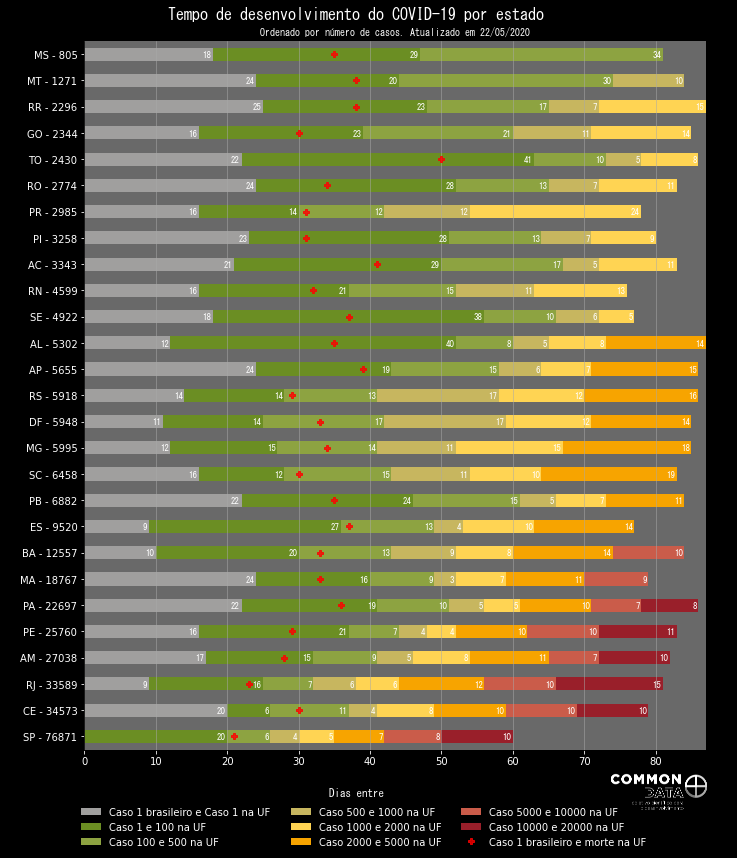

In [16]:
# With grey bar ordered by # of cases

covid_uf_summary.sort_values(by="new_confirmed", ascending = False, inplace=True)

creating_graph(covid_uf_summary, "número de casos")
    
plt.savefig('Tempo de desenvolvimento do Covid por estado_comcinza_numerodecasos.png', facecolor="black")

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


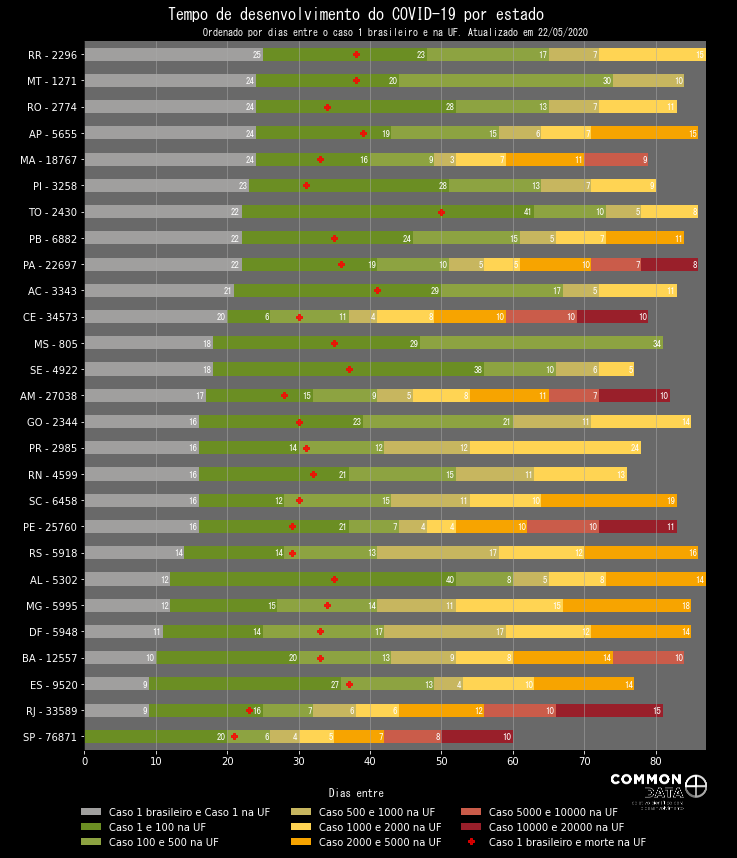

In [17]:
# With grey and ordered by First UF with cases

covid_uf_summary.sort_values(by=["Dias entre Caso 1 brasileiro e Caso 1 na UF", "new_confirmed"]
                             , ascending = (True, False), inplace=True)

creating_graph(covid_uf_summary, "dias entre o caso 1 brasileiro e na UF")
    
plt.savefig('Tempo de desenvolvimento do Covid por estado_comcinza_primeiro atingidas.png', facecolor="black")

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


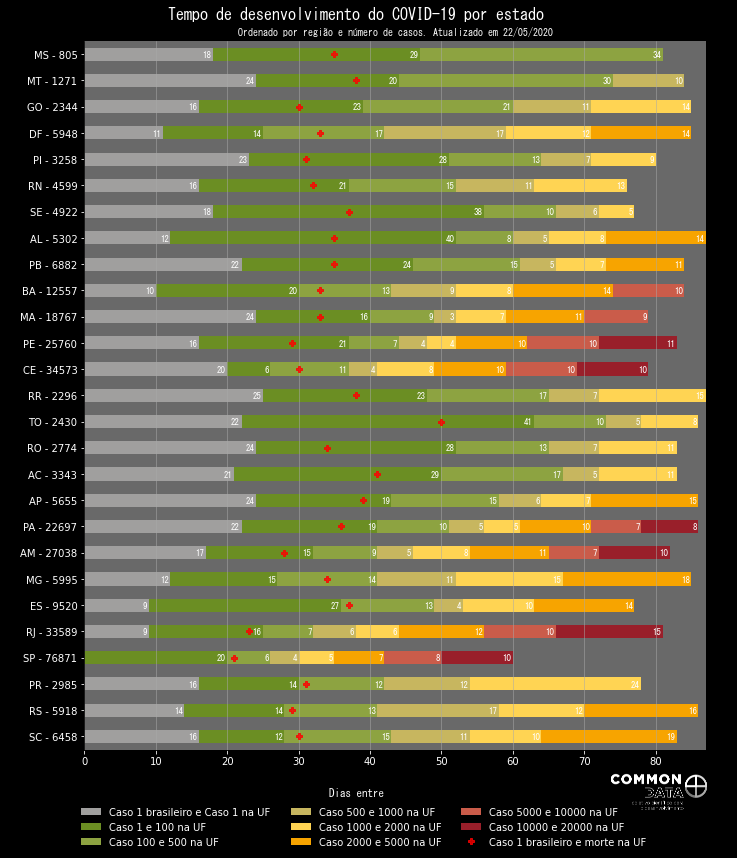

In [18]:
# With grey and ordered by Region and # cases

covid_uf_summary.sort_values(by=["Region", "new_confirmed"]
                             , ascending = (False, False), inplace=True)

creating_graph(covid_uf_summary, "região e número de casos")
    
plt.savefig('Tempo de desenvolvimento do Covid por estado_comcinza_regiao.png', facecolor="black")

In [19]:
columns_for_graph = [k for k in list(covid_uf_summary.columns)  if 'Dias entre Caso' in k]
columns_for_graph.remove('Dias entre Caso 1 brasileiro e morte na UF')
columns_for_graph.remove('Dias entre Caso 1 e morte na UF')
columns_for_graph.remove('Dias entre Caso 1 brasileiro e Caso 1 na UF')
print(columns_for_graph[::-1])

# colors = ["#8B0000", "#B22222","#DC143C", "#CD5C5C", "#F08080", "#E9967A", "#FA8072", "#FFA07A"][::-1]
# colors = ["#006400", "#6B8E23", "#8da341", "#c7b65f", "#FFA07A", "#e57155", "#DC143C", "#8B0000"]
# colors = ["#A09F9E", "#6B8E23", "#8da341", "#c7b65f", "#FFD453", "#F7A400", "#CA5C4A", "#991f2a"]
colors = ["#6B8E23", "#8da341", "#c7b65f", "#FFD453", "#F7A400", "#CA5C4A", "#991f2a"]

['Dias entre Caso 10000 e 20000 na UF', 'Dias entre Caso 5000 e 10000 na UF', 'Dias entre Caso 2000 e 5000 na UF', 'Dias entre Caso 1000 e 2000 na UF', 'Dias entre Caso 500 e 1000 na UF', 'Dias entre Caso 100 e 500 na UF', 'Dias entre Caso 1 e 100 na UF']


C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


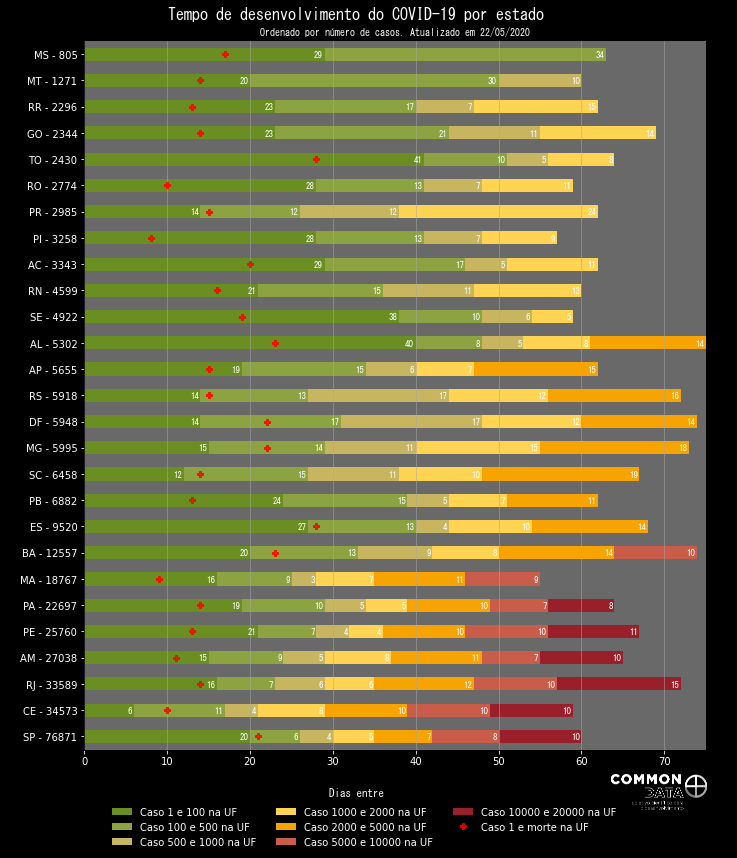

In [20]:
# Without grey and ordered by number of cases

covid_uf_summary.sort_values(by=["new_confirmed"]
                             , ascending = False, inplace=True)

creating_graph(covid_uf_summary, "número de casos", 0)
    
plt.savefig('Tempo de desenvolvimento do Covid por estado_semcinza_numerodecasos.png', facecolor="black")

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


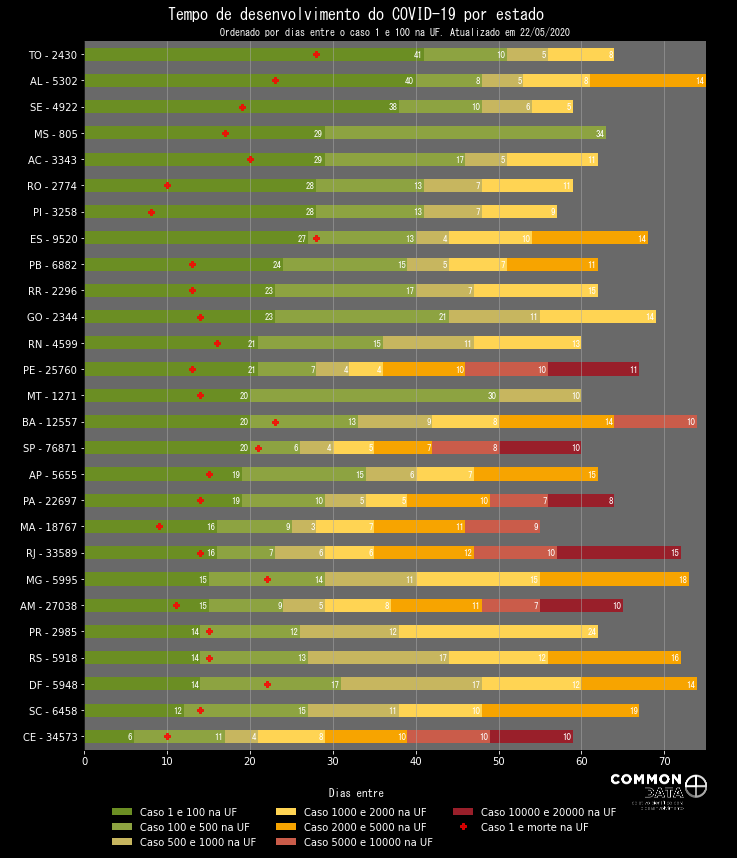

In [21]:
# Without grey and ordered by First UF with cases

covid_uf_summary.sort_values(by=["Dias entre Caso 1 e 100 na UF", "new_confirmed"]
                             , ascending = (True, False), inplace=True)

creating_graph(covid_uf_summary, "dias entre o caso 1 e 100 na UF", 0)
    
plt.savefig('Tempo de desenvolvimento do Covid por estado_semcinza_primeiro atingidas.png', facecolor="black")

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


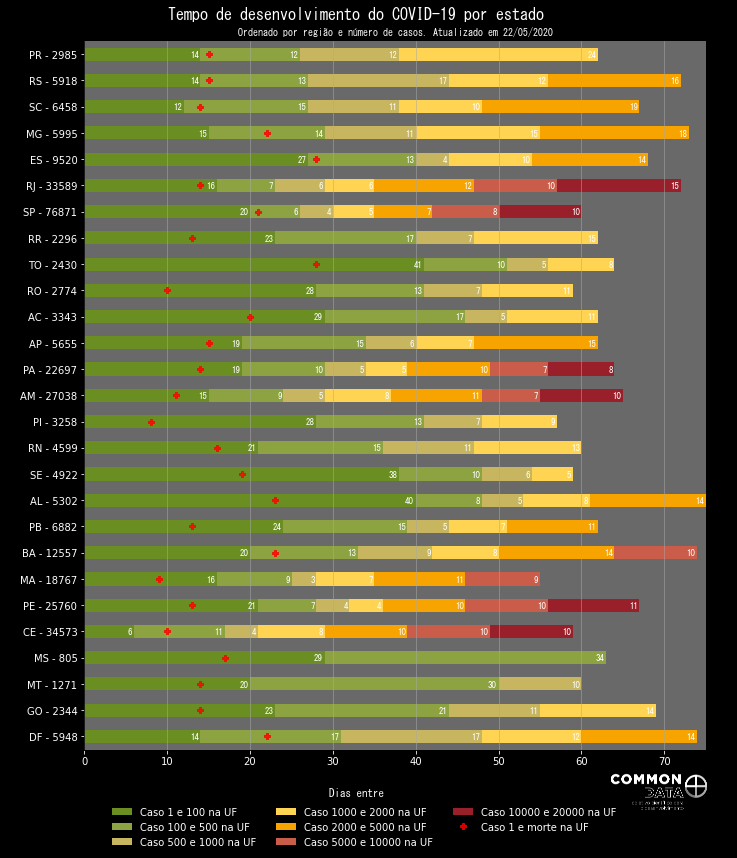

In [22]:
# Without grey and ordered by Region and # cases

covid_uf_summary.sort_values(by=["Region", "new_confirmed"]
                             , ascending = (True, False), inplace=True)

creating_graph(covid_uf_summary, "região e número de casos", 0)
    
plt.savefig('Tempo de desenvolvimento do Covid por estado_semcinza_regiao.png', facecolor="black")